In [1]:
import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
import numpy as np

from grr import pltools
from grr.Tools import dashedBorder, raiseExpectedGot, assertAllAlmostSame
from grr.cell_class import Cell, Recording, max_normalize_channel

In [3]:
DATA_PATH = os.path.join('data', 'processed', 'gating')
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

Load curves.

In [4]:
pdata = {}
for fname in os.listdir(DATA_PATH):
    if 'pdata' in fname:
        with open(os.path.join(DATA_PATH, fname), 'rb') as f:
            pdata[fname.split('_')[0]] = pickle.load(f)
            f.close()
    else:
        continue

fittedpts = {}
for fname in os.listdir(DATA_PATH):
    if 'fittedpts' in fname:
        with open(os.path.join(DATA_PATH, fname), 'rb') as f:
            fittedpts[fname.split('_')[0]] = pickle.load(f)
            f.close()
    else:
        continue
        
with open(os.path.join(DATA_PATH, 'gating_params.dat'), 'rb') as f:
    params = pickle.load(f)
    f.close()

Load sample trace.

In [5]:
TRACE_PATH = './data/raw/5HT/gating/'

beautiful_gating_1 = Cell().read_ABF([TRACE_PATH + '18619018.abf',
                                      TRACE_PATH + '18619019.abf',
                                      TRACE_PATH + '18619020.abf'])
beautiful_gating_1 = Recording(np.array(beautiful_gating_1).mean(axis = 0))
beautiful_gating_1.set_dt(0.1)

# Trace plot

/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


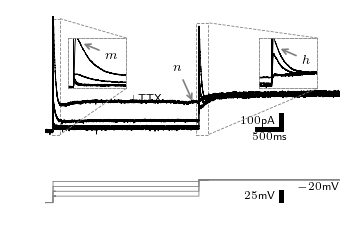

In [6]:
spec_trace = gs.GridSpec(2, 1, height_ratios=[1, 0.2])

plt.figure(figsize=(3, 2))

act_ax = plt.subplot(spec_trace[0, :])
Kslow_xlim = (2450, 8500)
plt.plot(
    beautiful_gating_1.t_mat[0, :, -2::-3],
    beautiful_gating_1[0, :, -2::-3], 'k-',
    linewidth = 0.5
)
plt.text(4500, 200, '+TTX', ha = 'center', va = 'center', size = 'small')
plt.annotate(
    '$n$', (5500, 170),
    xytext = (-10, 20), textcoords = 'offset points', ha = 'center',
    arrowprops = {'arrowstyle': '->'}
)
plt.xlim(Kslow_xlim)
plt.ylim(-100, 800)
pltools.add_scalebar(
    'ms', 'pA', anchor = (0.8, 0.1),
    x_label_space = -0.02, y_size = 100, x_size = 500, bar_space = 0
)

act_ins = inset_axes(act_ax, '20%', '40%', loc = 'upper left', borderpad = 2)
act_ins.plot(
    beautiful_gating_1.t_mat[0, :, -2::-3],
    beautiful_gating_1[0, :, -2::-3], 'k-',
    linewidth = 0.5
)
plt.annotate(
    '$m$', (2625, 705),
    xytext = (15, -10), textcoords = 'offset points',
    arrowprops = {'arrowstyle': '->'}
)
dashedBorder(act_ins)
#pltools.add_scalebar(y_units = 'pA', x_units = 'ms', remove_frame = False, ax = act_ins)
pltools.hide_ticks()
plt.xlim(2590, 2750)
plt.ylim(-50, 780)
mark_inset(act_ax, act_ins, loc1 = 1, loc2 = 4, ls = '--', color = 'gray', lw = 0.5)

inact_ins = inset_axes(act_ax, '20%', '40%', loc = 'upper right', borderpad = 2)
inact_ins.plot(
    beautiful_gating_1.t_mat[0, :, -3::-3],
    beautiful_gating_1[0, :, -3::-3], 'k-',
    linewidth = 0.5
)
plt.annotate(
    '$h$', (5630, 600),
    xytext = (15, -10), textcoords = 'offset points',
    arrowprops = {'arrowstyle': '->'}
)
dashedBorder(inact_ins)
#pltools.add_scalebar(y_units = 'pA', x_units = 'ms', remove_frame = False, ax = inact_ins)
pltools.hide_ticks()
plt.xlim(5550, 5800)
plt.ylim(-50, 750)
mark_inset(act_ax, inact_ins, loc1 = 1, loc2 = 4, ls = '--', color = 'gray', lw = 0.5)

plt.subplot(spec_trace[1, :])
plt.plot(
    beautiful_gating_1.t_mat[1, :, -2::-3],
    beautiful_gating_1[1, :, -2::-3], '-',
    color = 'gray', linewidth = 0.5
)
plt.xlim(Kslow_xlim)
plt.text(Kslow_xlim[1], -22, '$-20$mV', ha = 'right', va = 'top', size = 'small')
pltools.add_scalebar(y_units = 'mV', omit_x = True, anchor = (0.8, 0.1))

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_gating_experiment.png'))

Normalize conductance values.

In [7]:
for key in pdata:
    pdata[key][0, ...] = max_normalize_channel(pdata[key][0, ...])

# Gating plot

In [8]:
def get_plot_coordinates_with_error(pdata, error_type='sem'):
    if error_type not in ['std', 'sem']:
        raiseExpectedGot('`std` or `sem`', 'argument `error_type`', error_type)
        
    # Ensure voltages are same for all observations.
    for i in range(pdata.shape[1]):
        assertAllAlmostSame(pdata[1, i, :])  # Voltage channel should be [1, :, :]
    
    x = pdata[1, ...].mean(axis=1)
    y_mean = pdata[0, ...].mean(axis=1)
    y_std = pdata[0, ...].std(axis=1)
    if error_type == 'sem':
        y_err = y_std / np.sqrt(pdata.shape[2])
    elif error_type == 'std':
        y_err = y_std
    else:
        raise RuntimeError('Unexpectedly reached end of switch.')
    
    return {'x': x, 'y': y_mean, 'yerr': y_err}

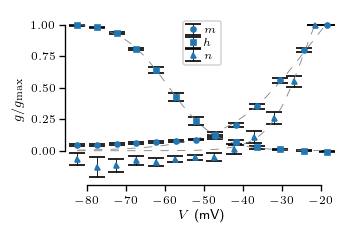

In [9]:
plt_params = {'ls': 'none', 'capsize': 5, 'ecolor': 'k', 'markersize': 3}

plt.figure(figsize=(3, 2))

plt.errorbar(
    marker='o', label='$m$', 
    **dict(plt_params, **get_plot_coordinates_with_error(pdata['peakact']))
)
plt.errorbar(
    marker='s', label='$h$', 
    **dict(plt_params, **get_plot_coordinates_with_error(pdata['peakinact']))
)
plt.errorbar(
    marker='^', label='$n$', 
    **dict(plt_params, **get_plot_coordinates_with_error(pdata['ss']))
)
for key in fittedpts:
    plt.plot(fittedpts[key][1, :], fittedpts[key][0, :], '--', color='gray', dashes=(10, 10))
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel('$V$ (mV)')
plt.ylabel(r'$g/g_{\mathrm{max}}$')
plt.legend(loc='upper center')

sns.despine(trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_gating_curves.png'))